## **0. Download dataset**

In [ ]:
# https://drive.google.com/file/d/1GaTMURqIQTjtalbNVAyVgPIEis21A0r8/view?usp=drive_link
!gdown --id 1GaTMURqIQTjtalbNVAyVgPIEis21A0r8

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8
From (redirected): https://drive.google.com/uc?id=1GaTMURqIQTjtalbNVAyVgPIEis21A0r8&confirm=t&uuid=63b96624-1e4b-478c-9eea-d6cd81248cc8
To: /content/FER-2013.zip
100% 63.3M/63.3M [00:00<00:00, 75.6MB/s]


In [ ]:
!unzip -q './FER-2013.zip'

## **1. Import libraries**

In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

## **2. Get classes**

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

classes = os.listdir(train_dir)

label2idx = {cls:idx for idx, cls in enumerate(classes)}
idx2label = {idx:cls  for cls, idx in label2idx.items()}

## **3. Create PyTorch DataLoader**

In [ ]:
test_img_path = '/content/train/angry/Training_10118481.jpg'
img = cv2.imread(test_img_path)
img_height, img_width = (128, 128)
print(f'Image height: {img_height}')
print(f'Image width: {img_width}')

Image height: 128
Image width: 128


In [ ]:
class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx,
                 split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.img_dir = img_dir
        self.norm = norm
        self.label2idx = label2idx
        self.split = split
        self.train_ratio = train_ratio
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
          train_data, val_data = train_test_split(
              list(zip(self.img_paths, self.img_labels)),
              train_size=train_ratio,
              random_state=random_state,
              stratify=self.img_labels
          )

          if split == 'train':
            self.img_paths, self.img_labels = zip(*train_data)
          elif split == 'val':
            self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)

        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
          img = (img/127.5)-1
        return img, label

In [ ]:
batch_size = 256

train_dataset = ImageDataset(
    img_dir=train_dir,
    norm=True,
    label2idx=label2idx,
    split='train')
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True)

val_dataset = ImageDataset(
    img_dir=train_dir,
    norm=True,
    label2idx=label2idx,
    split='val')
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False)

## **4. Build MLP network**

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims*4)
        self.linear2 = nn.Linear(hidden_dims*4, hidden_dims*2)
        self.linear3 = nn.Linear(hidden_dims*2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        out = self.output(x)
        return out.squeeze(1)

In [ ]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims, hidden_dims, output_dims).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## **5. Training**

In [ ]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [ ]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()

            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 1.900	Validation loss: 1.867

EPOCH 2:	Training loss: 1.839	Validation loss: 1.819

EPOCH 3:	Training loss: 1.807	Validation loss: 1.800

EPOCH 4:	Training loss: 1.791	Validation loss: 1.787

EPOCH 5:	Training loss: 1.777	Validation loss: 1.774

EPOCH 6:	Training loss: 1.764	Validation loss: 1.761

EPOCH 7:	Training loss: 1.749	Validation loss: 1.745

EPOCH 8:	Training loss: 1.731	Validation loss: 1.726

EPOCH 9:	Training loss: 1.710	Validation loss: 1.705

EPOCH 10:	Training loss: 1.688	Validation loss: 1.686

EPOCH 11:	Training loss: 1.671	Validation loss: 1.669

EPOCH 12:	Training loss: 1.655	Validation loss: 1.656

EPOCH 13:	Training loss: 1.642	Validation loss: 1.646

EPOCH 14:	Training loss: 1.631	Validation loss: 1.637

EPOCH 15:	Training loss: 1.621	Validation loss: 1.629

EPOCH 16:	Training loss: 1.612	Validation loss: 1.625

EPOCH 17:	Training loss: 1.603	Validation loss: 1.619

EPOCH 18:	Training loss: 1.595	Validation loss: 1.612

EPOCH 19:	Training

## **7. Evaluation**

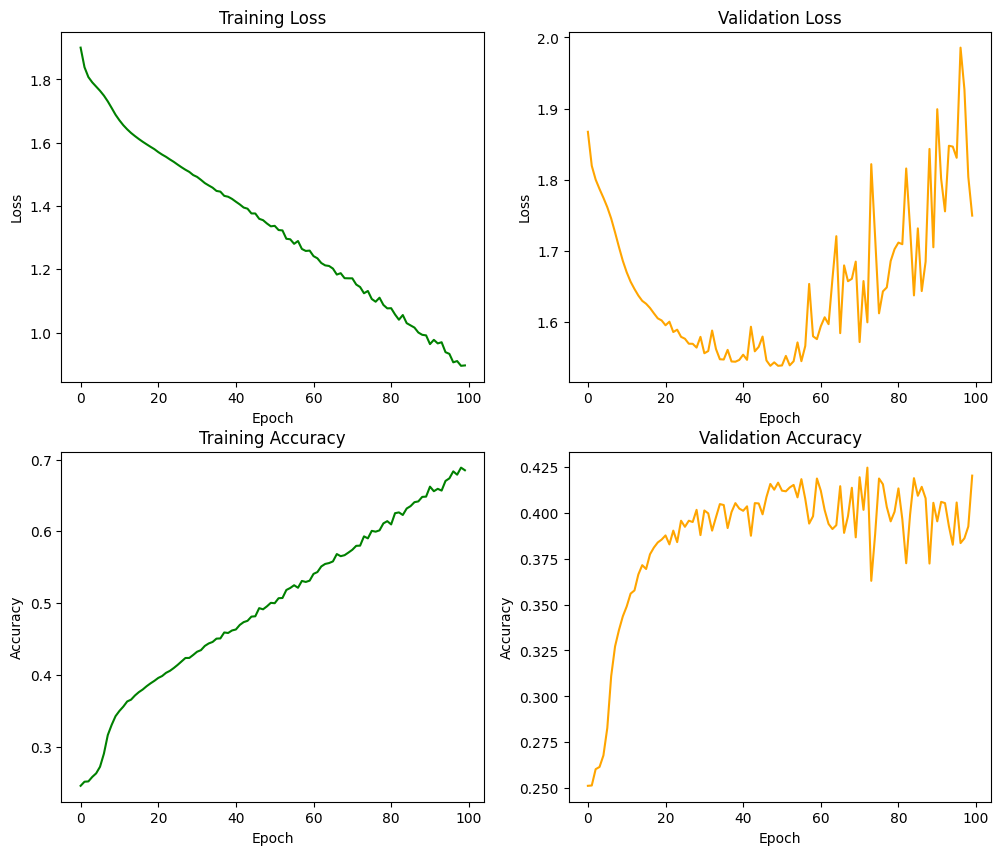

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [ ]:
val_target = []
val_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in val_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        val_predict.append(outputs.cpu())
        val_target.append(y_samples.cpu())

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)

    print('Evaluation on val set:')
    print(f'Accuracy: {val_acc}')

Evaluation on val set:
Accuracy: 0.42023685127133403
